## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [138]:
x = torch.rand(5, 3)
y = torch.rand(3, 5)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [139]:
torch.mm(x, y, out=z)

tensor([[0.5258, 0.6836, 0.2071, 0.6715, 1.3801],
        [0.1969, 0.8961, 0.2381, 0.9075, 1.2291],
        [0.3727, 0.9794, 0.2598, 1.0665, 1.8534],
        [0.2211, 0.3676, 0.0962, 0.4471, 0.9910],
        [0.4030, 0.7176, 0.2090, 0.7003, 1.2233]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [140]:
def relu_forward(x):
    return torch.where(x > 0, x, torch.zeros(size=x.size()))

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [22]:
def elu_forward(x):
    x[x < 0] = math.e ** x[x < 0] - 1
    return x

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [23]:
def lrelu_forward(x, alpha):
    return torch.where(x > 0, x, x * alpha)

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [24]:
def mish(x):
    return x*torch.tanh(torch.log(1+torch.exp(x)))

In [25]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

In [26]:
assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [27]:
def swish(x):
    standart = 1/(1+torch.exp(-x))
    return x * standart

In [28]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к линейной регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [103]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [104]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999, t=1):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2, t=t)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        t = group['t']
        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_m(param)
            self._init_adam_v(param)

            g = param.grad

            m = self._get_adam_m(param)
            v = self._get_adam_v(param)

            m *= beta_1
            v *= beta_2

            m += g * (1 - beta_1)
            v += (g ** 2) * (1 - beta_2)

            m_hat = m / (1 - beta_1**t)
            v_hat = v / (1 - beta_2**t)
            t +=1 
            d_param = m_hat / torch.sqrt(v_hat + eps)
            
            param.add_(d_param, alpha=-lr)

            #buffer.add_(d_param ** 2)



    def _get_adam_m(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['adam_m']

    def _get_adam_v(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        param_state = self.state[param]
        return param_state['adam_v']

    def _init_adam_m(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adam_m' not in param_state:
            param_state['adam_m'] = torch.zeros_like(param)

    def _init_adam_v(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        if 'adam_v' not in param_state:
            param_state['adam_v'] = torch.zeros_like(param)

**Task**: Создайте параметры для обучения линейной регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [105]:
def xavier(n_in, n_out):
    return torch.Tensor(n_in, n_out).uniform_(-1, 1)*math.sqrt(6./(n_in+n_out))

784 - потому что картинка 28*28, 10 - количество классов

In [106]:
weights = xavier(784, 10)
intercept = torch.Tensor(1, 10).uniform_(-1, 1)*math.sqrt(6./(784+10))

In [107]:
weights.requires_grad = True

In [108]:
optimizer = Adam([weights, intercept])
loss = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [109]:
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=2
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=128, num_workers=2
)

Напишите функцию для тренировки логистической регрессии, она должна:
 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [110]:
def model(x): 
    return x @ weights + bias

In [111]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    x, y = batch[0].reshape(-1, 784), batch[1]
    # предсказание
    pred = model(x)
    # считаем лосс
    losses = loss(pred, y)
    losses.backward()
    # делаем шаг оптимизации
    optimizer.step()
    # обнуляем посчитанные градиенты
    optimizer.zero_grad()
    # а вот и метрики
    accuracy = (pred.argmax(1) == y).float().mean()
    return [accuracy, losses]

In [112]:
def test_logistic_regression(batch, loss):
    with torch.no_grad():
        y_pred = model(batch[0].reshape(-1, 784))
        losses = loss(y_pred, batch[1])
        eval_acc.extend((torch.argmax(y_pred, dim=-1) == batch[1]).numpy().tolist())
        eval_losses.append(losses.item())

In [113]:
bias = torch.zeros(10, requires_grad=True)

In [114]:
from tqdm import tqdm

In [115]:
accuracies = []
losses = []
test_acc = []
test_losses = []
# тут меня посетила не очень умная идея, как понять где модель переобучилась, заранее excusez-moi
loss_epoch_train = []
tick = 0
for epoch in tqdm(range(1, 100)):
    for batch in train_dataloader:
        current_loss = []
        metrics = train_logistic_regression(weights, intercept, batch, loss, optimizer)
        accuracies.append(metrics[0].item())
        losses.append(metrics[1].item())
        current_loss.append(metrics[1].item())
    loss_epoch_train.append([epoch, np.mean(current_loss)])
    eval_losses = []
    eval_acc = []
    for batch in eval_dataloader:
        test_logistic_regression(batch, loss)
        test_acc.append(np.mean(eval_acc))
        test_losses.append(np.mean(eval_losses))

100%|██████████| 99/99 [10:55<00:00,  6.62s/it]


##### Зависимость лосса от итераций

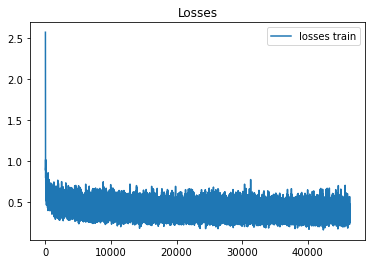

In [116]:
plt.plot(losses, label='losses train')
plt.title('Losses')
plt.legend()
plt.show()

##### Зависимость accuracy от итераций

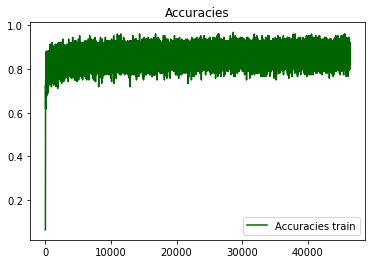

In [117]:
plt.plot(accuracies, label='Accuracies train', color='darkgreen')
plt.title('Accuracies')
plt.legend()
plt.show()

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

##### Ответики:


##### Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
По началу будет несмещенная оценка, так как на начальных этапах m и v только инициализируются и поэтому мы очень биаснуты к нулю. Адам фиксит это добро благодаря beta^t, на бесконечности бета стремится к нулю, и это хорошо, так как когда мы разберемся в пространстве и пройдем достаточное количество шагов, то накопим инфу и будем идти в правильном направлении

##### Когда модель начала переобучаться?
Я не эксперт, но походу модель не переобучилась, потому что на тренировочной выборке лосс держится в одних и тех же значениях... стыдно за мою визуализицию! 

In [119]:
losses_epoch = [row[1] for row in loss_epoch_train]

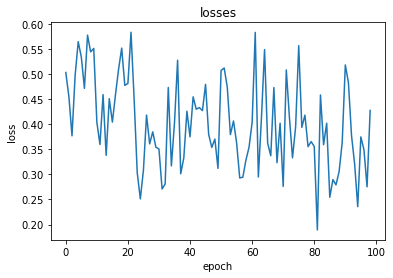

In [120]:
plt.plot(losses_epoch)
plt.title('losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

### Функции для обучения моделей

In [4]:
def train_epoch(model, data_loader, optimizer, criterion, return_losses=False, device='cuda:0'):
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device='cuda:0').reshape(-1, 784)
            labels = labels.to(device='cuda:0')
            predicted = model(images)
            loss = criterion(predicted, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics

In [5]:
def validate(model, data_loader, criterion, device='cuda:0'):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.reshape(-1, 784)
            images = images.to(device='cuda:0')
            labels = labels.to(device='cuda:0')
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

In [6]:
def fit(model, epochs, train_data_loader, validation_data_loader, optimizer, criterion):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion
        )
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion
            )
        epoch_eval_losses.append(validation_metrics['loss'])
    return epoch_train_losses

### Модель 1: Полносвязная модель

In [122]:
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.l1 = nn.Linear(784, 200)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x)

Модель с оптимизатором SGD with momentum

In [125]:
first_model = FirstModel().to(device='cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(first_model.parameters(), momentum=0.9, lr=0.001)

In [126]:
first_model_train_losses_SGD = fit(first_model, 10, train_dataloader, eval_dataloader, optimizer, criterion)

Train Epoch: 0
Loss: 2.2966 Accuracy: 10.1562:   2%|▏         | 9/469 [00:00<00:47,  9.77it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Loss: 0.928 Accuracy: 63.5417: 100%|██████████| 469/469 [00:06<00:00, 68.40it/s] 
Validation Epoch: 0
Loss: 0.8816 Accuracy: 68.75: 100%|██████████| 79/79 [00:01<00:00, 70.07it/s]  
Train Epoch: 1
Loss: 0.8021 Accuracy: 65.625: 100%|██████████| 469/469 [00:07<00:00, 58.86it/s] 
Validation Epoch: 1
Loss: 0.5555 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 69.52it/s]   
Train Epoch: 2
Loss: 0.6535 Accuracy: 79.1667: 100%|██████████| 469/469 [00:07<00:00, 64.30it/s]
Validation Epoch: 2
Loss: 0.4218 Accuracy: 81.25: 100%|██████████| 79/79 [00:01<00:00, 71.11it/s]  
Train Epoch: 3
Loss: 0.5108 Accuracy: 80.2083: 100%|██████████| 469/469 [00:06<00:00, 73.23it/s]
Validation Epoch: 3
Loss: 0.3693 Accuracy: 93.75: 100%|██████████| 79/79 [00:01<00:00, 71.16it/s]  
Train Epoch: 4
Loss: 0.4841 Accuracy: 83.3333: 100%|██████████| 469/469 [00:06<00:00, 68.22it/s]
Validation Epoch: 4
Loss: 0.3538 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 68.05it/s]   
Train Epoch: 5
Loss: 0.6114 Ac

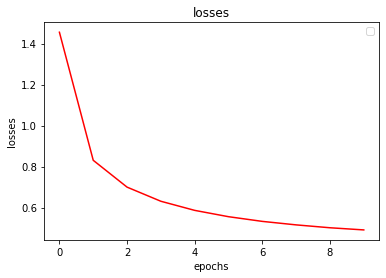

In [243]:
plt.plot(first_model_train_losses_SGD, color='red')
plt.title('losses')
plt.ylabel('losses')
plt.xlabel('epochs')
plt.show()

Модель с RMSprop оптимизатором

In [245]:
first_model = FirstModel().to(device='cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(first_model.parameters(), lr=0.001)

In [246]:
first_model_train_losses_RMSprop = fit(first_model, 10, train_dataloader, eval_dataloader, optimizer, criterion)

Train Epoch: 0
  0%|          | 0/469 [00:00<?, ?it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 2.318 Accuracy: 16.4062:   0%|          | 1/469 [00:00<00:51,  9.16it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 2.2251 Accuracy: 20.3125:   0%|          | 1/469 [00:00<00:51,  9.16it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 3.6382 Accuracy: 17.9688:   0%|          | 2/469 [00:00<00:50,  9.16it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 2.3592 Accuracy: 49.2188:   1%|          | 3/469 [00:00<00:50,  9.16it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 1.3756 Accuracy: 56.25:   1%|          | 4/469 [00:00<00:50,  9.16it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 1.3571 Accuracy: 43.75:   1%|          | 5/469 [00:00<00:50,  9.16it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 1.0951 Accuracy: 66.4062:   1%|▏         | 6/469 [00:00<00:50,  9.16it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 1.226 Accuracy: 59.375:   1%|▏         | 7/469 [00:00<00:50,  9.16it/s

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


torch.Size([128])
torch.Size([128, 10])
Loss: 0.7971 Accuracy: 74.2188:   3%|▎         | 16/469 [00:00<00:36, 12.51it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.811 Accuracy: 66.4062:   4%|▍         | 18/469 [00:00<00:27, 16.69it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.8792 Accuracy: 73.4375:   4%|▍         | 18/469 [00:00<00:27, 16.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.9994 Accuracy: 64.0625:   4%|▍         | 19/469 [00:00<00:26, 16.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.8215 Accuracy: 69.5312:   4%|▍         | 20/469 [00:00<00:26, 16.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.9874 Accuracy: 63.2812:   4%|▍         | 21/469 [00:00<00:26, 16.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.8683 Accuracy: 71.875:   5%|▍         | 22/469 [00:00<00:26, 16.69it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.8043 Accuracy: 66.4062:   5%|▍         | 23/469 [00:00<00:26, 16.69it/s]torch.Size([128])
torch.Size([128, 10])


Loss: 0.659 Accuracy: 74.2188:  18%|█▊        | 84/469 [00:01<00:06, 60.65it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.7104 Accuracy: 74.2188:  18%|█▊        | 85/469 [00:01<00:06, 60.65it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5966 Accuracy: 77.3438:  18%|█▊        | 86/469 [00:01<00:06, 60.65it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5773 Accuracy: 78.9062:  19%|█▊        | 87/469 [00:01<00:06, 60.65it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.6089 Accuracy: 85.1562:  19%|█▉        | 89/469 [00:01<00:05, 64.65it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.7066 Accuracy: 75.0:  19%|█▉        | 89/469 [00:01<00:05, 64.65it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.5763 Accuracy: 79.6875:  19%|█▉        | 90/469 [00:01<00:05, 64.65it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5665 Accuracy: 81.25:  19%|█▉        | 91/469 [00:01<00:05, 64.65it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.6958 Accuracy: 76.5625:  20%|█▉ 

Loss: 0.5762 Accuracy: 79.6875:  33%|███▎      | 153/469 [00:02<00:04, 70.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4915 Accuracy: 83.5938:  33%|███▎      | 153/469 [00:02<00:04, 70.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5916 Accuracy: 83.5938:  33%|███▎      | 154/469 [00:02<00:04, 70.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5128 Accuracy: 81.25:  33%|███▎      | 155/469 [00:02<00:04, 70.69it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.6325 Accuracy: 77.3438:  33%|███▎      | 156/469 [00:02<00:04, 70.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5522 Accuracy: 81.25:  33%|███▎      | 157/469 [00:02<00:04, 70.69it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.7697 Accuracy: 72.6562:  34%|███▎      | 158/469 [00:02<00:04, 70.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5856 Accuracy: 74.2188:  34%|███▍      | 159/469 [00:02<00:04, 70.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4719 Accuracy: 88.2812: 

Loss: 0.4378 Accuracy: 85.1562:  47%|████▋     | 221/469 [00:03<00:05, 43.47it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5842 Accuracy: 81.25:  47%|████▋     | 221/469 [00:03<00:05, 43.47it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.5415 Accuracy: 76.5625:  47%|████▋     | 222/469 [00:03<00:05, 43.47it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5897 Accuracy: 74.2188:  48%|████▊     | 223/469 [00:03<00:05, 43.47it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5324 Accuracy: 78.9062:  48%|████▊     | 224/469 [00:03<00:05, 43.47it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4274 Accuracy: 86.7188:  48%|████▊     | 225/469 [00:03<00:05, 43.47it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5177 Accuracy: 82.8125:  48%|████▊     | 227/469 [00:03<00:05, 47.38it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3767 Accuracy: 87.5:  48%|████▊     | 227/469 [00:03<00:05, 47.38it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.4195 Accuracy: 82.0312: 

Loss: 0.5707 Accuracy: 77.3438:  61%|██████▏   | 288/469 [00:04<00:02, 61.05it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4899 Accuracy: 81.25:  62%|██████▏   | 289/469 [00:04<00:02, 61.05it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.3777 Accuracy: 85.9375:  62%|██████▏   | 290/469 [00:04<00:02, 61.05it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4769 Accuracy: 82.8125:  62%|██████▏   | 292/469 [00:04<00:02, 62.88it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4133 Accuracy: 82.8125:  62%|██████▏   | 292/469 [00:04<00:02, 62.88it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4182 Accuracy: 85.1562:  62%|██████▏   | 293/469 [00:04<00:02, 62.88it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4945 Accuracy: 81.25:  63%|██████▎   | 294/469 [00:04<00:02, 62.88it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.4395 Accuracy: 85.1562:  63%|██████▎   | 295/469 [00:04<00:02, 62.88it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4503 Accuracy: 85.1562: 

Loss: 0.3136 Accuracy: 90.625:  76%|███████▌  | 356/469 [00:05<00:01, 67.14it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.5086 Accuracy: 85.1562:  76%|███████▌  | 357/469 [00:05<00:01, 67.14it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4405 Accuracy: 83.5938:  76%|███████▋  | 358/469 [00:05<00:01, 67.14it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4657 Accuracy: 85.1562:  77%|███████▋  | 360/469 [00:05<00:01, 63.88it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4615 Accuracy: 81.25:  77%|███████▋  | 360/469 [00:05<00:01, 63.88it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.5007 Accuracy: 79.6875:  77%|███████▋  | 361/469 [00:05<00:01, 63.88it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4884 Accuracy: 84.375:  77%|███████▋  | 362/469 [00:05<00:01, 63.88it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.4132 Accuracy: 85.9375:  77%|███████▋  | 363/469 [00:05<00:01, 63.88it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.6268 Accuracy: 81.25:  7

Loss: 0.5438 Accuracy: 80.4688:  90%|█████████ | 424/469 [00:06<00:00, 62.68it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5302 Accuracy: 85.1562:  91%|█████████ | 425/469 [00:06<00:00, 62.68it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.555 Accuracy: 82.8125:  91%|█████████ | 426/469 [00:06<00:00, 62.68it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.5369 Accuracy: 79.6875:  91%|█████████ | 427/469 [00:06<00:00, 62.68it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2697 Accuracy: 89.8438:  91%|█████████▏| 428/469 [00:06<00:00, 62.68it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4233 Accuracy: 82.8125:  91%|█████████▏| 429/469 [00:06<00:00, 62.68it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4003 Accuracy: 85.1562:  92%|█████████▏| 431/469 [00:06<00:00, 63.25it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3167 Accuracy: 88.2812:  92%|█████████▏| 431/469 [00:06<00:00, 63.25it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4561 Accuracy: 84.375:  

Loss: 0.3114 Accuracy: 89.0625:   5%|▍         | 22/469 [00:00<00:25, 17.23it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4305 Accuracy: 84.375:   5%|▍         | 23/469 [00:00<00:25, 17.23it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.4145 Accuracy: 85.9375:   5%|▌         | 24/469 [00:00<00:25, 17.23it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.321 Accuracy: 88.2812:   6%|▌         | 26/469 [00:00<00:19, 22.28it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2474 Accuracy: 92.9688:   6%|▌         | 26/469 [00:00<00:19, 22.28it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.435 Accuracy: 82.8125:   6%|▌         | 27/469 [00:00<00:19, 22.28it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.367 Accuracy: 85.1562:   6%|▌         | 28/469 [00:00<00:19, 22.28it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3888 Accuracy: 84.375:   6%|▌         | 29/469 [00:00<00:19, 22.28it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5337 Accuracy: 81.25:   6%|▋      

Loss: 0.3661 Accuracy: 87.5:  19%|█▉        | 91/469 [00:01<00:05, 64.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3837 Accuracy: 88.2812:  19%|█▉        | 91/469 [00:01<00:05, 64.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4843 Accuracy: 78.9062:  20%|█▉        | 92/469 [00:01<00:05, 64.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.387 Accuracy: 88.2812:  20%|█▉        | 93/469 [00:01<00:05, 64.42it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.5017 Accuracy: 82.8125:  20%|██        | 94/469 [00:01<00:05, 64.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3757 Accuracy: 89.0625:  20%|██        | 95/469 [00:01<00:05, 64.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4037 Accuracy: 83.5938:  20%|██        | 96/469 [00:01<00:05, 64.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4258 Accuracy: 83.5938:  21%|██        | 97/469 [00:01<00:05, 64.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3197 Accuracy: 89.8438:  21%|██    

Loss: 0.4004 Accuracy: 84.375:  34%|███▎      | 158/469 [00:02<00:04, 68.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3988 Accuracy: 89.0625:  34%|███▍      | 159/469 [00:02<00:04, 68.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2792 Accuracy: 91.4062:  34%|███▍      | 160/469 [00:02<00:04, 68.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3057 Accuracy: 87.5:  35%|███▍      | 162/469 [00:02<00:04, 68.11it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2935 Accuracy: 88.2812:  35%|███▍      | 162/469 [00:02<00:04, 68.11it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4352 Accuracy: 86.7188:  35%|███▍      | 163/469 [00:02<00:04, 68.11it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3535 Accuracy: 83.5938:  35%|███▍      | 164/469 [00:02<00:04, 68.11it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4106 Accuracy: 85.9375:  35%|███▌      | 165/469 [00:02<00:04, 68.11it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.576 Accuracy: 76.5625:  3

Loss: 0.5187 Accuracy: 80.4688:  48%|████▊     | 227/469 [00:03<00:03, 73.49it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.331 Accuracy: 87.5:  48%|████▊     | 227/469 [00:03<00:03, 73.49it/s]    torch.Size([128])
torch.Size([128, 10])
Loss: 0.3779 Accuracy: 88.2812:  49%|████▊     | 228/469 [00:03<00:03, 73.49it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4965 Accuracy: 75.7812:  49%|████▉     | 229/469 [00:03<00:03, 73.49it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5196 Accuracy: 80.4688:  49%|████▉     | 230/469 [00:03<00:03, 73.49it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5328 Accuracy: 82.8125:  49%|████▉     | 231/469 [00:03<00:03, 73.49it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4731 Accuracy: 82.0312:  49%|████▉     | 232/469 [00:03<00:03, 73.49it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5738 Accuracy: 80.4688:  50%|████▉     | 233/469 [00:03<00:03, 73.49it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.368 Accuracy: 85.9375:  

Loss: 0.3685 Accuracy: 89.0625:  63%|██████▎   | 294/469 [00:04<00:03, 45.26it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3766 Accuracy: 85.1562:  63%|██████▎   | 295/469 [00:04<00:03, 45.26it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4005 Accuracy: 85.1562:  63%|██████▎   | 297/469 [00:04<00:03, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4486 Accuracy: 84.375:  63%|██████▎   | 297/469 [00:04<00:03, 46.31it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.4246 Accuracy: 85.9375:  64%|██████▎   | 298/469 [00:04<00:03, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4136 Accuracy: 82.8125:  64%|██████▍   | 299/469 [00:04<00:03, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4292 Accuracy: 85.1562:  64%|██████▍   | 300/469 [00:04<00:03, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4102 Accuracy: 85.1562:  64%|██████▍   | 302/469 [00:04<00:03, 46.70it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4019 Accuracy: 83.5938: 

Loss: 0.4219 Accuracy: 84.375:  77%|███████▋  | 362/469 [00:05<00:01, 54.19it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3879 Accuracy: 82.8125:  78%|███████▊  | 364/469 [00:05<00:01, 53.50it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3578 Accuracy: 85.9375:  78%|███████▊  | 364/469 [00:05<00:01, 53.50it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4421 Accuracy: 85.1562:  78%|███████▊  | 365/469 [00:05<00:01, 53.50it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3671 Accuracy: 89.0625:  78%|███████▊  | 366/469 [00:05<00:01, 53.50it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3547 Accuracy: 88.2812:  78%|███████▊  | 367/469 [00:05<00:01, 53.50it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2887 Accuracy: 90.625:  78%|███████▊  | 368/469 [00:05<00:01, 53.50it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.4799 Accuracy: 84.375:  79%|███████▉  | 370/469 [00:05<00:01, 53.67it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4282 Accuracy: 82.8125:  7

Loss: 0.2789 Accuracy: 88.2812:  92%|█████████▏| 431/469 [00:06<00:00, 65.86it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3269 Accuracy: 89.0625:  92%|█████████▏| 431/469 [00:06<00:00, 65.86it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3724 Accuracy: 83.5938:  92%|█████████▏| 432/469 [00:06<00:00, 65.86it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4145 Accuracy: 83.5938:  92%|█████████▏| 433/469 [00:06<00:00, 65.86it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3959 Accuracy: 87.5:  93%|█████████▎| 434/469 [00:06<00:00, 65.86it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.4726 Accuracy: 86.7188:  93%|█████████▎| 435/469 [00:06<00:00, 65.86it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4025 Accuracy: 84.375:  93%|█████████▎| 436/469 [00:07<00:00, 65.86it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.5536 Accuracy: 77.3438:  93%|█████████▎| 437/469 [00:07<00:00, 65.86it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.6056 Accuracy: 75.7812: 

Loss: 0.5832 Accuracy: 82.0312:   6%|▌         | 28/469 [00:00<00:20, 21.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3519 Accuracy: 85.1562:   6%|▌         | 29/469 [00:00<00:20, 21.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4478 Accuracy: 85.9375:   6%|▋         | 30/469 [00:00<00:20, 21.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.425 Accuracy: 82.0312:   7%|▋         | 32/469 [00:00<00:15, 27.31it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3362 Accuracy: 91.4062:   7%|▋         | 32/469 [00:00<00:15, 27.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3288 Accuracy: 85.9375:   7%|▋         | 33/469 [00:00<00:15, 27.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3784 Accuracy: 88.2812:   7%|▋         | 34/469 [00:00<00:15, 27.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3874 Accuracy: 82.0312:   7%|▋         | 35/469 [00:00<00:15, 27.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4715 Accuracy: 81.25:   8%|▊    

Loss: 0.4105 Accuracy: 84.375:  20%|██        | 96/469 [00:01<00:06, 62.13it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3135 Accuracy: 87.5:  21%|██        | 97/469 [00:01<00:05, 62.13it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.2859 Accuracy: 89.0625:  21%|██        | 99/469 [00:01<00:05, 66.51it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3274 Accuracy: 89.0625:  21%|██        | 99/469 [00:01<00:05, 66.51it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4866 Accuracy: 88.2812:  21%|██▏       | 100/469 [00:01<00:05, 66.51it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4567 Accuracy: 82.0312:  22%|██▏       | 101/469 [00:01<00:05, 66.51it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5165 Accuracy: 82.0312:  22%|██▏       | 102/469 [00:01<00:05, 66.51it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4758 Accuracy: 83.5938:  22%|██▏       | 103/469 [00:01<00:05, 66.51it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3936 Accuracy: 83.5938:  22%|

Loss: 0.3656 Accuracy: 85.9375:  35%|███▍      | 164/469 [00:02<00:04, 72.55it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.323 Accuracy: 89.0625:  35%|███▌      | 165/469 [00:02<00:04, 72.55it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.4488 Accuracy: 85.1562:  35%|███▌      | 166/469 [00:02<00:04, 72.55it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4125 Accuracy: 83.5938:  36%|███▌      | 167/469 [00:02<00:04, 72.55it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3361 Accuracy: 88.2812:  36%|███▌      | 168/469 [00:02<00:04, 72.55it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3828 Accuracy: 85.1562:  36%|███▌      | 170/469 [00:02<00:04, 71.07it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3433 Accuracy: 86.7188:  36%|███▌      | 170/469 [00:02<00:04, 71.07it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2921 Accuracy: 88.2812:  36%|███▋      | 171/469 [00:02<00:04, 71.07it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3572 Accuracy: 86.7188: 

Loss: 0.2455 Accuracy: 91.4062:  49%|████▉     | 232/469 [00:03<00:03, 72.04it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3503 Accuracy: 90.625:  50%|████▉     | 234/469 [00:03<00:03, 70.90it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.5251 Accuracy: 84.375:  50%|████▉     | 234/469 [00:03<00:03, 70.90it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4157 Accuracy: 81.25:  50%|█████     | 235/469 [00:03<00:03, 70.90it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3695 Accuracy: 82.8125:  50%|█████     | 236/469 [00:03<00:03, 70.90it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4123 Accuracy: 84.375:  51%|█████     | 237/469 [00:03<00:03, 70.90it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3611 Accuracy: 83.5938:  51%|█████     | 238/469 [00:03<00:03, 70.90it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4171 Accuracy: 87.5:  51%|█████     | 239/469 [00:03<00:03, 70.90it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.31 Accuracy: 90.625:  51%|

Loss: 0.3372 Accuracy: 87.5:  64%|██████▍   | 300/469 [00:04<00:02, 71.91it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.455 Accuracy: 84.375:  64%|██████▍   | 301/469 [00:04<00:02, 71.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3362 Accuracy: 88.2812:  64%|██████▍   | 302/469 [00:04<00:02, 71.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3303 Accuracy: 89.8438:  65%|██████▍   | 303/469 [00:04<00:02, 71.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2315 Accuracy: 92.9688:  65%|██████▍   | 304/469 [00:04<00:02, 71.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2647 Accuracy: 91.4062:  65%|██████▌   | 306/469 [00:04<00:02, 70.56it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3892 Accuracy: 85.1562:  65%|██████▌   | 306/469 [00:04<00:02, 70.56it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3695 Accuracy: 88.2812:  65%|██████▌   | 307/469 [00:04<00:02, 70.56it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3477 Accuracy: 86.7188:  6

Loss: 0.4365 Accuracy: 84.375:  78%|███████▊  | 368/469 [00:05<00:01, 71.36it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2464 Accuracy: 90.625:  79%|███████▉  | 370/469 [00:05<00:01, 72.24it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.385 Accuracy: 87.5:  79%|███████▉  | 370/469 [00:05<00:01, 72.24it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.4409 Accuracy: 87.5:  79%|███████▉  | 371/469 [00:05<00:01, 72.24it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4443 Accuracy: 89.0625:  79%|███████▉  | 372/469 [00:05<00:01, 72.24it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4 Accuracy: 87.5:  80%|███████▉  | 373/469 [00:05<00:01, 72.24it/s]      torch.Size([128])
torch.Size([128, 10])
Loss: 0.2769 Accuracy: 89.8438:  80%|███████▉  | 374/469 [00:05<00:01, 72.24it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2617 Accuracy: 91.4062:  80%|███████▉  | 375/469 [00:05<00:01, 72.24it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2768 Accuracy: 92.9688:  80%|

Loss: 0.351 Accuracy: 88.2812:  93%|█████████▎| 436/469 [00:06<00:00, 74.26it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2902 Accuracy: 89.8438:  93%|█████████▎| 437/469 [00:06<00:00, 74.26it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4657 Accuracy: 82.8125:  93%|█████████▎| 438/469 [00:06<00:00, 74.26it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4702 Accuracy: 83.5938:  94%|█████████▎| 439/469 [00:06<00:00, 74.26it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3217 Accuracy: 92.1875:  94%|█████████▍| 440/469 [00:06<00:00, 74.26it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.395 Accuracy: 85.9375:  94%|█████████▍| 442/469 [00:06<00:00, 72.43it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.4019 Accuracy: 84.375:  94%|█████████▍| 442/469 [00:06<00:00, 72.43it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3367 Accuracy: 89.0625:  94%|█████████▍| 443/469 [00:06<00:00, 72.43it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3699 Accuracy: 82.8125:  9

Loss: 0.3503 Accuracy: 88.2812:   7%|▋         | 34/469 [00:00<00:16, 26.76it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.352 Accuracy: 89.0625:   7%|▋         | 35/469 [00:00<00:16, 26.76it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.302 Accuracy: 87.5:   8%|▊         | 36/469 [00:00<00:16, 26.76it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2529 Accuracy: 89.0625:   8%|▊         | 37/469 [00:00<00:16, 26.76it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2406 Accuracy: 91.4062:   8%|▊         | 38/469 [00:00<00:16, 26.76it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2696 Accuracy: 88.2812:   8%|▊         | 39/469 [00:00<00:16, 26.76it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2477 Accuracy: 89.8438:   9%|▊         | 41/469 [00:00<00:12, 32.98it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2769 Accuracy: 87.5:   9%|▊         | 41/469 [00:00<00:12, 32.98it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2336 Accuracy: 91.4062:   9%|▉   

Loss: 0.2524 Accuracy: 89.8438:  22%|██▏       | 102/469 [00:01<00:05, 67.99it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2508 Accuracy: 90.625:  22%|██▏       | 103/469 [00:01<00:05, 67.99it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3274 Accuracy: 88.2812:  22%|██▏       | 105/469 [00:01<00:05, 63.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3167 Accuracy: 88.2812:  22%|██▏       | 105/469 [00:01<00:05, 63.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2449 Accuracy: 92.9688:  23%|██▎       | 106/469 [00:01<00:05, 63.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4793 Accuracy: 82.8125:  23%|██▎       | 107/469 [00:01<00:05, 63.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4847 Accuracy: 82.0312:  23%|██▎       | 108/469 [00:01<00:05, 63.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2863 Accuracy: 92.1875:  23%|██▎       | 109/469 [00:01<00:05, 63.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3979 Accuracy: 85.1562: 

Loss: 0.2475 Accuracy: 92.1875:  36%|███▌      | 170/469 [00:02<00:04, 70.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4218 Accuracy: 86.7188:  36%|███▋      | 171/469 [00:02<00:04, 70.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2718 Accuracy: 89.0625:  37%|███▋      | 172/469 [00:02<00:04, 70.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4432 Accuracy: 82.8125:  37%|███▋      | 173/469 [00:02<00:04, 70.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2986 Accuracy: 85.9375:  37%|███▋      | 174/469 [00:02<00:04, 70.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2943 Accuracy: 87.5:  37%|███▋      | 175/469 [00:02<00:04, 70.27it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2727 Accuracy: 90.625:  38%|███▊      | 176/469 [00:02<00:04, 70.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3527 Accuracy: 88.2812:  38%|███▊      | 178/469 [00:02<00:04, 69.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3654 Accuracy: 87.5:  38%

Loss: 0.3511 Accuracy: 86.7188:  51%|█████     | 238/469 [00:03<00:03, 72.30it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3046 Accuracy: 89.0625:  51%|█████     | 239/469 [00:03<00:03, 72.30it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3266 Accuracy: 91.4062:  51%|█████     | 240/469 [00:03<00:03, 72.30it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.383 Accuracy: 88.2812:  51%|█████▏    | 241/469 [00:03<00:03, 72.30it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3706 Accuracy: 85.1562:  52%|█████▏    | 243/469 [00:03<00:03, 71.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3951 Accuracy: 88.2812:  52%|█████▏    | 243/469 [00:03<00:03, 71.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3197 Accuracy: 85.9375:  52%|█████▏    | 244/469 [00:03<00:03, 71.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2026 Accuracy: 94.5312:  52%|█████▏    | 245/469 [00:03<00:03, 71.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2146 Accuracy: 93.75:  5

Loss: 0.3245 Accuracy: 85.1562:  65%|██████▌   | 306/469 [00:04<00:02, 70.97it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2737 Accuracy: 88.2812:  66%|██████▌   | 308/469 [00:04<00:02, 71.19it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.294 Accuracy: 89.0625:  66%|██████▌   | 308/469 [00:04<00:02, 71.19it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.4008 Accuracy: 84.375:  66%|██████▌   | 309/469 [00:04<00:02, 71.19it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2195 Accuracy: 92.1875:  66%|██████▌   | 310/469 [00:04<00:02, 71.19it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2857 Accuracy: 89.0625:  66%|██████▋   | 311/469 [00:04<00:02, 71.19it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2126 Accuracy: 92.1875:  67%|██████▋   | 312/469 [00:04<00:02, 71.19it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4095 Accuracy: 85.1562:  67%|██████▋   | 313/469 [00:04<00:02, 71.19it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4149 Accuracy: 83.5938:  

Loss: 0.3516 Accuracy: 89.8438:  80%|███████▉  | 374/469 [00:05<00:02, 38.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2969 Accuracy: 87.5:  80%|███████▉  | 375/469 [00:05<00:02, 38.22it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.3222 Accuracy: 87.5:  80%|████████  | 376/469 [00:05<00:02, 38.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3999 Accuracy: 85.9375:  80%|████████  | 377/469 [00:06<00:02, 38.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2702 Accuracy: 89.8438:  81%|████████  | 379/469 [00:06<00:02, 38.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2591 Accuracy: 89.0625:  81%|████████  | 379/469 [00:06<00:02, 38.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3796 Accuracy: 85.9375:  81%|████████  | 380/469 [00:06<00:02, 38.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2261 Accuracy: 91.4062:  81%|████████  | 381/469 [00:06<00:02, 38.69it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4037 Accuracy: 87.5:  81%|█

Loss: 0.3412 Accuracy: 87.5:  94%|█████████▍| 442/469 [00:07<00:00, 61.07it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2644 Accuracy: 89.0625:  94%|█████████▍| 443/469 [00:07<00:00, 61.07it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3087 Accuracy: 89.8438:  95%|█████████▍| 444/469 [00:07<00:00, 61.07it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3404 Accuracy: 85.9375:  95%|█████████▌| 446/469 [00:07<00:00, 63.86it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4685 Accuracy: 83.5938:  95%|█████████▌| 446/469 [00:07<00:00, 63.86it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.412 Accuracy: 87.5:  95%|█████████▌| 447/469 [00:07<00:00, 63.86it/s]    torch.Size([128])
torch.Size([128, 10])
Loss: 0.31 Accuracy: 89.8438:  96%|█████████▌| 448/469 [00:07<00:00, 63.86it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3112 Accuracy: 87.5:  96%|█████████▌| 449/469 [00:07<00:00, 63.86it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.4319 Accuracy: 82.0312:  96%

Loss: 0.4202 Accuracy: 84.375:   9%|▊         | 40/469 [00:00<00:14, 29.02it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2341 Accuracy: 91.4062:   9%|▉         | 42/469 [00:00<00:12, 35.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2751 Accuracy: 89.0625:   9%|▉         | 42/469 [00:00<00:12, 35.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2579 Accuracy: 92.9688:   9%|▉         | 43/469 [00:00<00:12, 35.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2789 Accuracy: 88.2812:   9%|▉         | 44/469 [00:00<00:12, 35.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2988 Accuracy: 90.625:  10%|▉         | 45/469 [00:00<00:11, 35.36it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2651 Accuracy: 89.0625:  10%|▉         | 46/469 [00:00<00:11, 35.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3631 Accuracy: 85.1562:  10%|█         | 47/469 [00:00<00:11, 35.36it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3577 Accuracy: 85.1562:  10%|█  

Loss: 0.2685 Accuracy: 91.4062:  23%|██▎       | 108/469 [00:01<00:05, 67.89it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3099 Accuracy: 89.8438:  23%|██▎       | 109/469 [00:01<00:05, 67.89it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.344 Accuracy: 89.0625:  23%|██▎       | 110/469 [00:01<00:05, 67.89it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3154 Accuracy: 87.5:  24%|██▎       | 111/469 [00:01<00:05, 67.89it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.2958 Accuracy: 89.8438:  24%|██▍       | 112/469 [00:01<00:05, 67.89it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4124 Accuracy: 84.375:  24%|██▍       | 113/469 [00:01<00:05, 67.89it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2309 Accuracy: 93.75:  25%|██▍       | 115/469 [00:01<00:06, 54.06it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3566 Accuracy: 86.7188:  25%|██▍       | 115/469 [00:01<00:06, 54.06it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3562 Accuracy: 85.1562:  2

Loss: 0.3106 Accuracy: 86.7188:  38%|███▊      | 176/469 [00:03<00:07, 39.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2646 Accuracy: 92.1875:  38%|███▊      | 177/469 [00:03<00:07, 39.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2823 Accuracy: 90.625:  38%|███▊      | 179/469 [00:03<00:06, 42.63it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.4178 Accuracy: 85.9375:  38%|███▊      | 179/469 [00:03<00:06, 42.63it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3874 Accuracy: 84.375:  38%|███▊      | 180/469 [00:03<00:06, 42.63it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3 Accuracy: 89.8438:  39%|███▊      | 181/469 [00:03<00:06, 42.63it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.2888 Accuracy: 89.8438:  39%|███▉      | 182/469 [00:03<00:06, 42.63it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2337 Accuracy: 92.1875:  39%|███▉      | 183/469 [00:03<00:06, 42.63it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3433 Accuracy: 89.8438:  

Loss: 0.3324 Accuracy: 89.0625:  52%|█████▏    | 244/469 [00:04<00:03, 59.19it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.269 Accuracy: 89.8438:  52%|█████▏    | 245/469 [00:04<00:03, 59.19it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2077 Accuracy: 94.5312:  52%|█████▏    | 246/469 [00:04<00:03, 59.19it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3034 Accuracy: 89.8438:  53%|█████▎    | 248/469 [00:04<00:03, 58.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4801 Accuracy: 82.0312:  53%|█████▎    | 248/469 [00:04<00:03, 58.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3053 Accuracy: 89.8438:  53%|█████▎    | 249/469 [00:04<00:03, 58.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2846 Accuracy: 91.4062:  53%|█████▎    | 250/469 [00:04<00:03, 58.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3225 Accuracy: 86.7188:  54%|█████▎    | 251/469 [00:04<00:03, 58.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2264 Accuracy: 89.8438: 

Loss: 0.234 Accuracy: 91.4062:  67%|██████▋   | 312/469 [00:05<00:02, 64.45it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3241 Accuracy: 85.1562:  67%|██████▋   | 313/469 [00:05<00:02, 64.45it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.5045 Accuracy: 75.7812:  67%|██████▋   | 314/469 [00:05<00:02, 64.45it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3302 Accuracy: 85.9375:  67%|██████▋   | 315/469 [00:05<00:02, 64.45it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3401 Accuracy: 88.2812:  67%|██████▋   | 316/469 [00:05<00:02, 64.45it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2 Accuracy: 92.9688:  68%|██████▊   | 317/469 [00:05<00:02, 64.45it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.301 Accuracy: 89.0625:  68%|██████▊   | 318/469 [00:05<00:02, 64.45it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.38 Accuracy: 85.9375:  68%|██████▊   | 320/469 [00:05<00:02, 66.54it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3368 Accuracy: 86.7188:  6

Loss: 0.2631 Accuracy: 89.0625:  81%|████████  | 380/469 [00:06<00:01, 69.53it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4379 Accuracy: 84.375:  81%|████████  | 381/469 [00:06<00:01, 69.53it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.313 Accuracy: 85.9375:  82%|████████▏ | 383/469 [00:06<00:01, 70.03it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.284 Accuracy: 92.1875:  82%|████████▏ | 383/469 [00:06<00:01, 70.03it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2252 Accuracy: 92.1875:  82%|████████▏ | 384/469 [00:06<00:01, 70.03it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.288 Accuracy: 88.2812:  82%|████████▏ | 385/469 [00:06<00:01, 70.03it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2971 Accuracy: 88.2812:  82%|████████▏ | 386/469 [00:06<00:01, 70.03it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.38 Accuracy: 84.375:  83%|████████▎ | 387/469 [00:06<00:01, 70.03it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2739 Accuracy: 89.0625:  8

Loss: 0.3136 Accuracy: 89.0625:  96%|█████████▌| 448/469 [00:07<00:00, 59.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3096 Accuracy: 89.8438:  96%|█████████▌| 449/469 [00:07<00:00, 59.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4239 Accuracy: 85.1562:  96%|█████████▌| 450/469 [00:07<00:00, 59.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3469 Accuracy: 89.0625:  96%|█████████▌| 451/469 [00:07<00:00, 59.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2051 Accuracy: 92.9688:  96%|█████████▋| 452/469 [00:07<00:00, 59.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3446 Accuracy: 82.8125:  97%|█████████▋| 454/469 [00:07<00:00, 61.44it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4164 Accuracy: 85.1562:  97%|█████████▋| 454/469 [00:07<00:00, 61.44it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3605 Accuracy: 87.5:  97%|█████████▋| 455/469 [00:07<00:00, 61.44it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2578 Accuracy: 93.75:  9

Loss: 0.3264 Accuracy: 89.0625:  10%|▉         | 46/469 [00:00<00:12, 34.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3101 Accuracy: 87.5:  10%|█         | 48/469 [00:00<00:10, 41.39it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.3603 Accuracy: 87.5:  10%|█         | 48/469 [00:00<00:10, 41.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2856 Accuracy: 87.5:  10%|█         | 49/469 [00:00<00:10, 41.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3492 Accuracy: 87.5:  11%|█         | 50/469 [00:00<00:10, 41.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2686 Accuracy: 89.8438:  11%|█         | 51/469 [00:00<00:10, 41.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2738 Accuracy: 86.7188:  11%|█         | 52/469 [00:00<00:10, 41.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3263 Accuracy: 87.5:  11%|█▏        | 53/469 [00:00<00:10, 41.39it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2341 Accuracy: 89.8438:  12%|█▏        | 

Loss: 0.1827 Accuracy: 92.9688:  24%|██▍       | 114/469 [00:02<00:07, 47.62it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3779 Accuracy: 87.5:  25%|██▍       | 116/469 [00:02<00:07, 45.55it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2156 Accuracy: 92.1875:  25%|██▍       | 116/469 [00:02<00:07, 45.55it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.342 Accuracy: 86.7188:  25%|██▍       | 117/469 [00:02<00:07, 45.55it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3174 Accuracy: 88.2812:  25%|██▌       | 118/469 [00:02<00:07, 45.55it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.231 Accuracy: 93.75:  25%|██▌       | 119/469 [00:02<00:07, 45.55it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.4128 Accuracy: 85.9375:  26%|██▌       | 121/469 [00:02<00:08, 43.06it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2459 Accuracy: 88.2812:  26%|██▌       | 121/469 [00:02<00:08, 43.06it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.379 Accuracy: 85.1562:  

Loss: 0.2718 Accuracy: 89.0625:  39%|███▉      | 182/469 [00:03<00:04, 62.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2642 Accuracy: 89.8438:  39%|███▉      | 183/469 [00:03<00:04, 62.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3412 Accuracy: 87.5:  39%|███▉      | 184/469 [00:03<00:04, 62.27it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.323 Accuracy: 89.0625:  39%|███▉      | 185/469 [00:03<00:04, 62.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2021 Accuracy: 92.1875:  40%|███▉      | 186/469 [00:03<00:04, 62.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3008 Accuracy: 89.0625:  40%|███▉      | 187/469 [00:03<00:04, 62.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4304 Accuracy: 85.1562:  40%|████      | 188/469 [00:03<00:04, 62.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3971 Accuracy: 85.9375:  41%|████      | 190/469 [00:03<00:04, 64.08it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2621 Accuracy: 89.0625:  

Loss: 0.322 Accuracy: 88.2812:  54%|█████▎    | 251/469 [00:04<00:04, 52.99it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3236 Accuracy: 87.5:  54%|█████▎    | 251/469 [00:04<00:04, 52.99it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.3613 Accuracy: 84.375:  54%|█████▎    | 252/469 [00:04<00:04, 52.99it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3056 Accuracy: 85.1562:  54%|█████▍    | 253/469 [00:04<00:04, 52.99it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3066 Accuracy: 89.8438:  54%|█████▍    | 254/469 [00:04<00:04, 52.99it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1669 Accuracy: 95.3125:  54%|█████▍    | 255/469 [00:04<00:04, 52.99it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.373 Accuracy: 83.5938:  55%|█████▍    | 257/469 [00:04<00:03, 54.32it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2442 Accuracy: 89.8438:  55%|█████▍    | 257/469 [00:04<00:03, 54.32it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3312 Accuracy: 88.2812:  55

Loss: 0.3798 Accuracy: 86.7188:  68%|██████▊   | 318/469 [00:05<00:02, 61.82it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3894 Accuracy: 86.7188:  68%|██████▊   | 319/469 [00:05<00:02, 61.82it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4282 Accuracy: 84.375:  68%|██████▊   | 320/469 [00:05<00:02, 61.82it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.311 Accuracy: 90.625:  68%|██████▊   | 321/469 [00:05<00:02, 61.82it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2833 Accuracy: 89.8438:  69%|██████▊   | 322/469 [00:05<00:02, 61.82it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3047 Accuracy: 91.4062:  69%|██████▉   | 323/469 [00:05<00:02, 61.82it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2911 Accuracy: 90.625:  69%|██████▉   | 324/469 [00:05<00:02, 61.82it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2587 Accuracy: 88.2812:  70%|██████▉   | 326/469 [00:05<00:02, 65.40it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3145 Accuracy: 90.625:  7

Loss: 0.3169 Accuracy: 89.8438:  82%|████████▏ | 386/469 [00:06<00:01, 69.96it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3385 Accuracy: 91.4062:  83%|████████▎ | 387/469 [00:06<00:01, 69.96it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2757 Accuracy: 86.7188:  83%|████████▎ | 388/469 [00:06<00:01, 69.96it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2572 Accuracy: 90.625:  83%|████████▎ | 390/469 [00:06<00:01, 71.71it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3321 Accuracy: 86.7188:  83%|████████▎ | 390/469 [00:06<00:01, 71.71it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2812 Accuracy: 89.8438:  83%|████████▎ | 391/469 [00:06<00:01, 71.71it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3735 Accuracy: 86.7188:  84%|████████▎ | 392/469 [00:06<00:01, 71.71it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3159 Accuracy: 88.2812:  84%|████████▍ | 393/469 [00:06<00:01, 71.71it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.367 Accuracy: 84.375:  8

Loss: 0.2141 Accuracy: 92.9688:  97%|█████████▋| 454/469 [00:07<00:00, 72.61it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2633 Accuracy: 90.625:  97%|█████████▋| 455/469 [00:07<00:00, 72.61it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2934 Accuracy: 89.0625:  97%|█████████▋| 456/469 [00:07<00:00, 72.61it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2863 Accuracy: 86.7188:  97%|█████████▋| 457/469 [00:07<00:00, 72.61it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2324 Accuracy: 90.625:  98%|█████████▊| 458/469 [00:07<00:00, 72.61it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2581 Accuracy: 88.2812:  98%|█████████▊| 459/469 [00:07<00:00, 72.61it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1899 Accuracy: 95.3125:  98%|█████████▊| 460/469 [00:07<00:00, 72.61it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2251 Accuracy: 91.4062:  99%|█████████▊| 462/469 [00:07<00:00, 72.72it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3426 Accuracy: 84.375:  

Loss: 0.2496 Accuracy: 91.4062:  11%|█         | 52/469 [00:00<00:10, 40.18it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2235 Accuracy: 91.4062:  11%|█▏        | 53/469 [00:00<00:10, 40.18it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2756 Accuracy: 92.1875:  12%|█▏        | 54/469 [00:00<00:10, 40.18it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2882 Accuracy: 90.625:  12%|█▏        | 56/469 [00:00<00:08, 46.59it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2862 Accuracy: 88.2812:  12%|█▏        | 56/469 [00:00<00:08, 46.59it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3135 Accuracy: 85.9375:  12%|█▏        | 57/469 [00:00<00:08, 46.59it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2275 Accuracy: 91.4062:  12%|█▏        | 58/469 [00:00<00:08, 46.59it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3392 Accuracy: 85.9375:  13%|█▎        | 59/469 [00:00<00:08, 46.59it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4415 Accuracy: 84.375:  13%|█▎  

Loss: 0.276 Accuracy: 86.7188:  26%|██▌       | 120/469 [00:01<00:05, 69.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2664 Accuracy: 89.8438:  26%|██▌       | 121/469 [00:01<00:05, 69.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2802 Accuracy: 87.5:  26%|██▌       | 122/469 [00:01<00:05, 69.22it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2275 Accuracy: 92.9688:  26%|██▌       | 123/469 [00:01<00:04, 69.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2871 Accuracy: 89.8438:  26%|██▋       | 124/469 [00:01<00:04, 69.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.315 Accuracy: 88.2812:  27%|██▋       | 125/469 [00:01<00:04, 69.22it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3168 Accuracy: 88.2812:  27%|██▋       | 126/469 [00:01<00:04, 69.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3076 Accuracy: 88.2812:  27%|██▋       | 128/469 [00:01<00:04, 69.66it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1911 Accuracy: 94.5312:  

Loss: 0.3354 Accuracy: 87.5:  40%|████      | 188/469 [00:02<00:04, 67.99it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.3195 Accuracy: 87.5:  41%|████      | 190/469 [00:02<00:04, 68.48it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1607 Accuracy: 92.1875:  41%|████      | 190/469 [00:02<00:04, 68.48it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.316 Accuracy: 87.5:  41%|████      | 191/469 [00:02<00:04, 68.48it/s]    torch.Size([128])
torch.Size([128, 10])
Loss: 0.3149 Accuracy: 90.625:  41%|████      | 192/469 [00:02<00:04, 68.48it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.359 Accuracy: 88.2812:  41%|████      | 193/469 [00:02<00:04, 68.48it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3934 Accuracy: 86.7188:  41%|████▏     | 194/469 [00:02<00:04, 68.48it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2397 Accuracy: 92.1875:  42%|████▏     | 195/469 [00:02<00:04, 68.48it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3271 Accuracy: 85.1562:  42%|

Loss: 0.2455 Accuracy: 89.0625:  55%|█████▍    | 256/469 [00:03<00:02, 72.72it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3817 Accuracy: 87.5:  55%|█████▍    | 257/469 [00:03<00:02, 72.72it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.3287 Accuracy: 91.4062:  55%|█████▌    | 258/469 [00:03<00:02, 72.72it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2677 Accuracy: 90.625:  55%|█████▌    | 259/469 [00:03<00:02, 72.72it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2192 Accuracy: 92.1875:  55%|█████▌    | 260/469 [00:03<00:02, 72.72it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2307 Accuracy: 91.4062:  56%|█████▌    | 261/469 [00:03<00:02, 72.72it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2568 Accuracy: 92.9688:  56%|█████▌    | 262/469 [00:03<00:02, 72.72it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2659 Accuracy: 91.4062:  56%|█████▋    | 264/469 [00:03<00:02, 72.56it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2966 Accuracy: 86.7188: 

Loss: 0.156 Accuracy: 93.75:  69%|██████▉   | 324/469 [00:04<00:02, 70.31it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.284 Accuracy: 88.2812:  69%|██████▉   | 325/469 [00:04<00:02, 70.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2571 Accuracy: 88.2812:  70%|██████▉   | 326/469 [00:04<00:02, 70.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3535 Accuracy: 83.5938:  70%|██████▉   | 327/469 [00:04<00:02, 70.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2377 Accuracy: 89.8438:  70%|███████   | 329/469 [00:04<00:01, 70.07it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.203 Accuracy: 91.4062:  70%|███████   | 329/469 [00:04<00:01, 70.07it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2208 Accuracy: 92.1875:  70%|███████   | 330/469 [00:04<00:01, 70.07it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2484 Accuracy: 90.625:  71%|███████   | 331/469 [00:04<00:01, 70.07it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.1862 Accuracy: 95.3125:  

Loss: 0.2919 Accuracy: 88.2812:  84%|████████▍ | 393/469 [00:05<00:01, 63.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2874 Accuracy: 88.2812:  84%|████████▍ | 393/469 [00:05<00:01, 63.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3071 Accuracy: 89.0625:  84%|████████▍ | 394/469 [00:05<00:01, 63.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3056 Accuracy: 88.2812:  84%|████████▍ | 395/469 [00:05<00:01, 63.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2491 Accuracy: 90.625:  84%|████████▍ | 396/469 [00:05<00:01, 63.01it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2871 Accuracy: 90.625:  85%|████████▍ | 397/469 [00:05<00:01, 63.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3389 Accuracy: 85.9375:  85%|████████▍ | 398/469 [00:05<00:01, 63.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3532 Accuracy: 89.0625:  85%|████████▌ | 399/469 [00:05<00:01, 63.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2457 Accuracy: 92.1875:  

Loss: 0.4086 Accuracy: 83.5938:  98%|█████████▊| 460/469 [00:06<00:00, 52.32it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3098 Accuracy: 90.625:  99%|█████████▊| 462/469 [00:06<00:00, 52.67it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3649 Accuracy: 86.7188:  99%|█████████▊| 462/469 [00:06<00:00, 52.67it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.287 Accuracy: 90.625:  99%|█████████▊| 463/469 [00:06<00:00, 52.67it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.2398 Accuracy: 92.9688:  99%|█████████▉| 464/469 [00:06<00:00, 52.67it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2387 Accuracy: 92.1875:  99%|█████████▉| 465/469 [00:06<00:00, 52.67it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2965 Accuracy: 89.0625:  99%|█████████▉| 466/469 [00:06<00:00, 52.67it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3792 Accuracy: 84.375: 100%|█████████▉| 468/469 [00:06<00:00, 54.34it/s] torch.Size([96])
torch.Size([96, 10])
Loss: 0.3233 Accuracy: 89.5833: 10

Loss: 0.3386 Accuracy: 86.7188:  13%|█▎        | 59/469 [00:00<00:08, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1913 Accuracy: 91.4062:  13%|█▎        | 59/469 [00:00<00:08, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2752 Accuracy: 91.4062:  13%|█▎        | 60/469 [00:00<00:08, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2689 Accuracy: 88.2812:  13%|█▎        | 61/469 [00:00<00:08, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2134 Accuracy: 90.625:  13%|█▎        | 62/469 [00:00<00:08, 46.31it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3682 Accuracy: 86.7188:  13%|█▎        | 63/469 [00:00<00:08, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2372 Accuracy: 92.9688:  14%|█▎        | 64/469 [00:00<00:08, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2927 Accuracy: 91.4062:  14%|█▍        | 65/469 [00:00<00:08, 46.31it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3432 Accuracy: 86.7188:  14%|█▍ 

Loss: 0.3557 Accuracy: 91.4062:  27%|██▋       | 126/469 [00:01<00:04, 69.37it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2748 Accuracy: 88.2812:  27%|██▋       | 127/469 [00:01<00:04, 69.37it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.26 Accuracy: 92.9688:  27%|██▋       | 128/469 [00:01<00:04, 69.37it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.3666 Accuracy: 84.375:  28%|██▊       | 130/469 [00:01<00:04, 69.23it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3526 Accuracy: 87.5:  28%|██▊       | 130/469 [00:01<00:04, 69.23it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.3733 Accuracy: 86.7188:  28%|██▊       | 131/469 [00:01<00:04, 69.23it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.356 Accuracy: 86.7188:  28%|██▊       | 132/469 [00:01<00:04, 69.23it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2913 Accuracy: 90.625:  28%|██▊       | 133/469 [00:01<00:04, 69.23it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3514 Accuracy: 86.7188:  29

Loss: 0.3234 Accuracy: 88.2812:  42%|████▏     | 195/469 [00:02<00:03, 71.09it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2081 Accuracy: 92.1875:  42%|████▏     | 195/469 [00:02<00:03, 71.09it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2816 Accuracy: 88.2812:  42%|████▏     | 196/469 [00:02<00:03, 71.09it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2745 Accuracy: 92.9688:  42%|████▏     | 197/469 [00:02<00:03, 71.09it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2796 Accuracy: 89.0625:  42%|████▏     | 198/469 [00:02<00:03, 71.09it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2534 Accuracy: 92.9688:  42%|████▏     | 199/469 [00:02<00:03, 71.09it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3487 Accuracy: 86.7188:  43%|████▎     | 200/469 [00:02<00:03, 71.09it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3514 Accuracy: 92.9688:  43%|████▎     | 201/469 [00:02<00:03, 71.09it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3414 Accuracy: 89.8438: 

Loss: 0.1699 Accuracy: 92.9688:  56%|█████▌    | 262/469 [00:03<00:02, 73.61it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1791 Accuracy: 95.3125:  56%|█████▌    | 263/469 [00:03<00:02, 73.61it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2635 Accuracy: 88.2812:  56%|█████▋    | 264/469 [00:03<00:02, 73.61it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2471 Accuracy: 90.625:  57%|█████▋    | 265/469 [00:03<00:02, 73.61it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2894 Accuracy: 89.8438:  57%|█████▋    | 267/469 [00:03<00:02, 70.46it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.184 Accuracy: 92.9688:  57%|█████▋    | 267/469 [00:03<00:02, 70.46it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2945 Accuracy: 90.625:  57%|█████▋    | 268/469 [00:03<00:02, 70.46it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3455 Accuracy: 86.7188:  57%|█████▋    | 269/469 [00:03<00:02, 70.46it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2513 Accuracy: 88.2812:  

Loss: 0.2876 Accuracy: 86.7188:  70%|███████   | 330/469 [00:04<00:01, 70.11it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2601 Accuracy: 91.4062:  71%|███████   | 332/469 [00:04<00:01, 71.43it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2056 Accuracy: 89.8438:  71%|███████   | 332/469 [00:04<00:01, 71.43it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4083 Accuracy: 86.7188:  71%|███████   | 333/469 [00:04<00:01, 71.43it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2168 Accuracy: 90.625:  71%|███████   | 334/469 [00:04<00:01, 71.43it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2136 Accuracy: 92.1875:  71%|███████▏  | 335/469 [00:04<00:01, 71.43it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1898 Accuracy: 91.4062:  72%|███████▏  | 336/469 [00:04<00:01, 71.43it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2682 Accuracy: 89.0625:  72%|███████▏  | 337/469 [00:04<00:01, 71.43it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3027 Accuracy: 88.2812: 

torch.Size([128, 10])
Loss: 0.2788 Accuracy: 92.9688:  85%|████████▍ | 398/469 [00:05<00:01, 70.15it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2185 Accuracy: 92.1875:  85%|████████▌ | 399/469 [00:05<00:00, 70.15it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3428 Accuracy: 86.7188:  85%|████████▌ | 400/469 [00:05<00:00, 70.15it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2872 Accuracy: 89.8438:  86%|████████▌ | 401/469 [00:05<00:00, 70.15it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2179 Accuracy: 90.625:  86%|████████▌ | 402/469 [00:05<00:00, 70.15it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.1513 Accuracy: 92.1875:  86%|████████▌ | 404/469 [00:05<00:00, 69.14it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2387 Accuracy: 91.4062:  86%|████████▌ | 404/469 [00:05<00:00, 69.14it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3038 Accuracy: 87.5:  86%|████████▋ | 405/469 [00:05<00:00, 69.14it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.27

Loss: 0.3294 Accuracy: 85.1562:  99%|█████████▉| 465/469 [00:06<00:00, 67.30it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.4249 Accuracy: 85.9375: 100%|█████████▉| 467/469 [00:06<00:00, 68.98it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3725 Accuracy: 85.9375: 100%|█████████▉| 467/469 [00:06<00:00, 68.98it/s]torch.Size([96])
torch.Size([96, 10])
Loss: 0.2763 Accuracy: 92.7083: 100%|██████████| 469/469 [00:06<00:00, 69.86it/s]
Validation Epoch: 7
Loss: 0.18 Accuracy: 93.75: 100%|██████████| 79/79 [00:01<00:00, 72.23it/s]    
Train Epoch: 8
  0%|          | 0/469 [00:00<?, ?it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2847 Accuracy: 87.5:   0%|          | 1/469 [00:00<00:50,  9.24it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2616 Accuracy: 90.625:   0%|          | 1/469 [00:00<00:50,  9.24it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2939 Accuracy: 90.625:   0%|          | 2/469 [00:00<00:50,  9.24it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.230

Loss: 0.2994 Accuracy: 86.7188:  14%|█▎        | 64/469 [00:00<00:07, 51.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2698 Accuracy: 90.625:  14%|█▎        | 64/469 [00:01<00:07, 51.27it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2305 Accuracy: 91.4062:  14%|█▍        | 65/469 [00:01<00:07, 51.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2635 Accuracy: 90.625:  14%|█▍        | 66/469 [00:01<00:07, 51.27it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.1961 Accuracy: 92.9688:  14%|█▍        | 67/469 [00:01<00:07, 51.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2773 Accuracy: 88.2812:  14%|█▍        | 68/469 [00:01<00:07, 51.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2119 Accuracy: 91.4062:  15%|█▍        | 69/469 [00:01<00:07, 51.27it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.25 Accuracy: 89.8438:  15%|█▍        | 70/469 [00:01<00:07, 51.27it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.1583 Accuracy: 92.9688:  15%|█▌ 

Loss: 0.2211 Accuracy: 91.4062:  28%|██▊       | 131/469 [00:02<00:06, 49.61it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.321 Accuracy: 88.2812:  28%|██▊       | 133/469 [00:02<00:06, 48.56it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2509 Accuracy: 90.625:  28%|██▊       | 133/469 [00:02<00:06, 48.56it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2568 Accuracy: 91.4062:  29%|██▊       | 134/469 [00:02<00:06, 48.56it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2748 Accuracy: 90.625:  29%|██▉       | 135/469 [00:02<00:06, 48.56it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2693 Accuracy: 89.0625:  29%|██▉       | 136/469 [00:02<00:06, 48.56it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.275 Accuracy: 89.0625:  29%|██▉       | 137/469 [00:02<00:06, 48.56it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2644 Accuracy: 88.2812:  30%|██▉       | 139/469 [00:02<00:06, 49.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2566 Accuracy: 92.1875:  

Loss: 0.2439 Accuracy: 89.8438:  42%|████▏     | 199/469 [00:03<00:04, 66.21it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2227 Accuracy: 90.625:  43%|████▎     | 200/469 [00:03<00:04, 66.21it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3327 Accuracy: 87.5:  43%|████▎     | 202/469 [00:03<00:04, 66.22it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.2451 Accuracy: 90.625:  43%|████▎     | 202/469 [00:03<00:04, 66.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3343 Accuracy: 88.2812:  43%|████▎     | 203/469 [00:03<00:04, 66.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2143 Accuracy: 91.4062:  43%|████▎     | 204/469 [00:03<00:04, 66.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3195 Accuracy: 89.0625:  44%|████▎     | 205/469 [00:03<00:03, 66.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2765 Accuracy: 92.1875:  44%|████▍     | 206/469 [00:03<00:03, 66.22it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3003 Accuracy: 90.625:  44

Loss: 0.3299 Accuracy: 87.5:  57%|█████▋    | 267/469 [00:04<00:02, 68.48it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.2247 Accuracy: 88.2812:  57%|█████▋    | 268/469 [00:04<00:02, 68.48it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2455 Accuracy: 90.625:  57%|█████▋    | 269/469 [00:04<00:02, 68.48it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2926 Accuracy: 86.7188:  58%|█████▊    | 271/469 [00:04<00:02, 68.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3213 Accuracy: 89.8438:  58%|█████▊    | 271/469 [00:04<00:02, 68.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2183 Accuracy: 91.4062:  58%|█████▊    | 272/469 [00:04<00:02, 68.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2144 Accuracy: 92.1875:  58%|█████▊    | 273/469 [00:04<00:02, 68.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1836 Accuracy: 92.9688:  58%|█████▊    | 274/469 [00:04<00:02, 68.01it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2109 Accuracy: 89.8438:  

Loss: 0.238 Accuracy: 89.8438:  71%|███████▏  | 335/469 [00:05<00:02, 65.57it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3033 Accuracy: 86.7188:  72%|███████▏  | 336/469 [00:05<00:02, 65.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2243 Accuracy: 89.0625:  72%|███████▏  | 338/469 [00:05<00:01, 65.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2467 Accuracy: 90.625:  72%|███████▏  | 338/469 [00:05<00:01, 65.91it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2345 Accuracy: 89.8438:  72%|███████▏  | 339/469 [00:05<00:01, 65.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2701 Accuracy: 91.4062:  72%|███████▏  | 340/469 [00:05<00:01, 65.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1711 Accuracy: 94.5312:  73%|███████▎  | 341/469 [00:05<00:01, 65.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2539 Accuracy: 89.8438:  73%|███████▎  | 342/469 [00:05<00:01, 65.91it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3608 Accuracy: 89.8438: 

Loss: 0.4129 Accuracy: 82.8125:  86%|████████▌ | 403/469 [00:06<00:00, 67.95it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.214 Accuracy: 92.9688:  86%|████████▌ | 404/469 [00:06<00:00, 67.95it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.1616 Accuracy: 94.5312:  86%|████████▋ | 405/469 [00:06<00:00, 67.95it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3821 Accuracy: 88.2812:  87%|████████▋ | 407/469 [00:06<00:00, 67.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1765 Accuracy: 96.0938:  87%|████████▋ | 407/469 [00:06<00:00, 67.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3097 Accuracy: 89.0625:  87%|████████▋ | 408/469 [00:06<00:00, 67.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3621 Accuracy: 85.9375:  87%|████████▋ | 409/469 [00:06<00:00, 67.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2579 Accuracy: 89.0625:  87%|████████▋ | 410/469 [00:06<00:00, 67.42it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2505 Accuracy: 91.4062: 

Loss: 0.2479 Accuracy: 92.1875:   0%|          | 0/469 [00:00<?, ?it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2623 Accuracy: 89.0625:   0%|          | 2/469 [00:00<00:24, 19.15it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2057 Accuracy: 94.5312:   0%|          | 2/469 [00:00<00:24, 19.15it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2343 Accuracy: 91.4062:   1%|          | 3/469 [00:00<00:24, 19.15it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.298 Accuracy: 86.7188:   1%|          | 4/469 [00:00<00:24, 19.15it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2031 Accuracy: 92.1875:   1%|          | 5/469 [00:00<00:24, 19.15it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3354 Accuracy: 88.2812:   1%|▏         | 6/469 [00:00<00:24, 19.15it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2291 Accuracy: 91.4062:   1%|▏         | 7/469 [00:00<00:24, 19.15it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2363 Accuracy: 90.625:   2%|▏         | 8/469 [0

Loss: 0.2943 Accuracy: 89.8438:  14%|█▍        | 68/469 [00:01<00:08, 48.68it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2463 Accuracy: 91.4062:  15%|█▍        | 69/469 [00:01<00:08, 48.68it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2173 Accuracy: 90.625:  15%|█▌        | 71/469 [00:01<00:08, 47.57it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2703 Accuracy: 90.625:  15%|█▌        | 71/469 [00:01<00:08, 47.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2831 Accuracy: 88.2812:  15%|█▌        | 72/469 [00:01<00:08, 47.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2014 Accuracy: 94.5312:  16%|█▌        | 73/469 [00:01<00:08, 47.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2531 Accuracy: 92.1875:  16%|█▌        | 74/469 [00:01<00:08, 47.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2263 Accuracy: 92.9688:  16%|█▌        | 75/469 [00:01<00:08, 47.57it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.162 Accuracy: 92.9688:  16%|█▋   

Loss: 0.4086 Accuracy: 88.2812:  29%|██▉       | 136/469 [00:02<00:04, 68.84it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2603 Accuracy: 88.2812:  29%|██▉       | 138/469 [00:02<00:04, 67.94it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2514 Accuracy: 92.9688:  29%|██▉       | 138/469 [00:02<00:04, 67.94it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2294 Accuracy: 93.75:  30%|██▉       | 139/469 [00:02<00:04, 67.94it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.2232 Accuracy: 91.4062:  30%|██▉       | 140/469 [00:02<00:04, 67.94it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2326 Accuracy: 90.625:  30%|███       | 141/469 [00:02<00:04, 67.94it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3599 Accuracy: 88.2812:  30%|███       | 142/469 [00:02<00:04, 67.94it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2219 Accuracy: 92.1875:  30%|███       | 143/469 [00:02<00:04, 67.94it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3465 Accuracy: 86.7188: 

Loss: 0.1899 Accuracy: 92.9688:  43%|████▎     | 204/469 [00:03<00:03, 71.70it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2714 Accuracy: 89.0625:  44%|████▎     | 205/469 [00:03<00:03, 71.70it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2142 Accuracy: 91.4062:  44%|████▍     | 206/469 [00:03<00:03, 71.70it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3324 Accuracy: 87.5:  44%|████▍     | 207/469 [00:03<00:03, 71.70it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.2611 Accuracy: 90.625:  45%|████▍     | 209/469 [00:03<00:03, 70.14it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1685 Accuracy: 93.75:  45%|████▍     | 209/469 [00:03<00:03, 70.14it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2807 Accuracy: 90.625:  45%|████▍     | 210/469 [00:03<00:03, 70.14it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2144 Accuracy: 92.1875:  45%|████▍     | 211/469 [00:03<00:03, 70.14it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2693 Accuracy: 91.4062:  45

Loss: 0.2453 Accuracy: 93.75:  58%|█████▊    | 273/469 [00:04<00:03, 50.79it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2642 Accuracy: 92.1875:  58%|█████▊    | 273/469 [00:04<00:03, 50.79it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1673 Accuracy: 92.9688:  58%|█████▊    | 274/469 [00:04<00:03, 50.79it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.276 Accuracy: 88.2812:  59%|█████▊    | 275/469 [00:04<00:03, 50.79it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2458 Accuracy: 89.0625:  59%|█████▉    | 276/469 [00:04<00:03, 50.79it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2479 Accuracy: 90.625:  59%|█████▉    | 277/469 [00:04<00:03, 50.79it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3236 Accuracy: 85.9375:  59%|█████▉    | 279/469 [00:04<00:03, 50.58it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2964 Accuracy: 88.2812:  59%|█████▉    | 279/469 [00:04<00:03, 50.58it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2216 Accuracy: 89.8438:  

Loss: 0.1924 Accuracy: 90.625:  72%|███████▏  | 340/469 [00:05<00:02, 62.39it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2644 Accuracy: 86.7188:  73%|███████▎  | 341/469 [00:05<00:02, 62.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2054 Accuracy: 92.9688:  73%|███████▎  | 342/469 [00:05<00:02, 62.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3791 Accuracy: 85.1562:  73%|███████▎  | 343/469 [00:05<00:02, 62.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2015 Accuracy: 92.9688:  73%|███████▎  | 344/469 [00:05<00:02, 62.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1845 Accuracy: 92.1875:  74%|███████▎  | 345/469 [00:05<00:01, 62.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2288 Accuracy: 91.4062:  74%|███████▍  | 346/469 [00:05<00:01, 62.39it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.204 Accuracy: 92.9688:  74%|███████▍  | 348/469 [00:05<00:01, 64.32it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.2394 Accuracy: 91.4062: 

Loss: 0.2217 Accuracy: 91.4062:  87%|████████▋ | 408/469 [00:06<00:00, 69.32it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2828 Accuracy: 87.5:  87%|████████▋ | 410/469 [00:06<00:00, 68.13it/s]   torch.Size([128])
torch.Size([128, 10])
Loss: 0.4576 Accuracy: 83.5938:  87%|████████▋ | 410/469 [00:06<00:00, 68.13it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1948 Accuracy: 90.625:  88%|████████▊ | 411/469 [00:06<00:00, 68.13it/s] torch.Size([128])
torch.Size([128, 10])
Loss: 0.3376 Accuracy: 85.1562:  88%|████████▊ | 412/469 [00:06<00:00, 68.13it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.2641 Accuracy: 91.4062:  88%|████████▊ | 413/469 [00:06<00:00, 68.13it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.1325 Accuracy: 93.75:  88%|████████▊ | 414/469 [00:06<00:00, 68.13it/s]  torch.Size([128])
torch.Size([128, 10])
Loss: 0.2179 Accuracy: 89.8438:  88%|████████▊ | 415/469 [00:06<00:00, 68.13it/s]torch.Size([128])
torch.Size([128, 10])
Loss: 0.3611 Accuracy: 89.8438: 

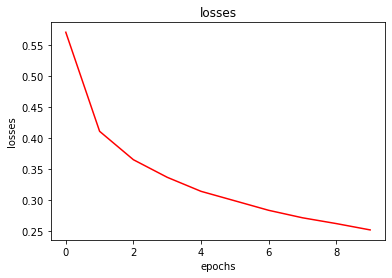

In [247]:
plt.plot(first_model_train_losses_RMSprop, color='red')
plt.title('losses')
plt.ylabel('losses')
plt.xlabel('epochs')
plt.show()

### Модель 2: VGG-подобная сеть

Модель с оптимизатором SGD with momentum

In [131]:
second_model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(200, 200),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(200, 10),
        )

second_model.to(device='cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(second_model.parameters(), momentum=0.9, lr=0.001)

In [250]:
second_model_train_losses_SGD = fit(second_model, 10, train_dataloader, eval_dataloader, optimizer, criterion)

Train Epoch: 0
Loss: 1.4904 Accuracy: 39.5833: 100%|██████████| 469/469 [00:06<00:00, 68.55it/s]
Validation Epoch: 0
Loss: 1.3966 Accuracy: 50.0: 100%|██████████| 79/79 [00:01<00:00, 72.25it/s]   
Train Epoch: 1
Loss: 0.8773 Accuracy: 70.8333: 100%|██████████| 469/469 [00:06<00:00, 68.74it/s]
Validation Epoch: 1
Loss: 0.7469 Accuracy: 62.5: 100%|██████████| 79/79 [00:01<00:00, 73.67it/s]   
Train Epoch: 2
Loss: 0.7173 Accuracy: 70.8333: 100%|██████████| 469/469 [00:06<00:00, 68.08it/s]
Validation Epoch: 2
Loss: 0.5401 Accuracy: 81.25: 100%|██████████| 79/79 [00:01<00:00, 69.87it/s]  
Train Epoch: 3
Loss: 0.5712 Accuracy: 80.2083: 100%|██████████| 469/469 [00:07<00:00, 62.66it/s]
Validation Epoch: 3
Loss: 0.4153 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 69.10it/s]   
Train Epoch: 4
Loss: 0.6062 Accuracy: 76.0417: 100%|██████████| 469/469 [00:07<00:00, 66.16it/s]
Validation Epoch: 4
Loss: 0.3607 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 67.27it/s]   
Train Epoch: 5


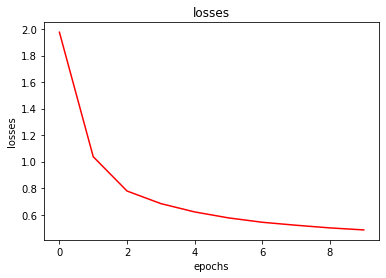

In [251]:
plt.plot(second_model_train_losses_SGD, color='red')
plt.title('losses')
plt.ylabel('losses')
plt.xlabel('epochs')
plt.show()

Модель с RMSprop оптимизатором

In [252]:
second_model.to(device='cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(second_model.parameters(), lr=0.001)

In [253]:
second_model_train_losses_RMSprop = fit(second_model, 10, train_dataloader, eval_dataloader, optimizer, criterion)

Train Epoch: 0
Loss: 0.3651 Accuracy: 87.5: 100%|██████████| 469/469 [00:07<00:00, 64.94it/s]   
Validation Epoch: 0
Loss: 0.3205 Accuracy: 81.25: 100%|██████████| 79/79 [00:01<00:00, 49.91it/s]  
Train Epoch: 1
Loss: 0.2597 Accuracy: 89.5833: 100%|██████████| 469/469 [00:07<00:00, 62.66it/s]
Validation Epoch: 1
Loss: 0.219 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 67.82it/s]    
Train Epoch: 2
Loss: 0.2712 Accuracy: 91.6667: 100%|██████████| 469/469 [00:07<00:00, 64.39it/s]
Validation Epoch: 2
Loss: 0.3213 Accuracy: 81.25: 100%|██████████| 79/79 [00:01<00:00, 74.72it/s]  
Train Epoch: 3
Loss: 0.2454 Accuracy: 89.5833: 100%|██████████| 469/469 [00:06<00:00, 68.58it/s]
Validation Epoch: 3
Loss: 0.2228 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 72.68it/s]   
Train Epoch: 4
Loss: 0.248 Accuracy: 88.5417: 100%|██████████| 469/469 [00:07<00:00, 66.47it/s] 
Validation Epoch: 4
Loss: 0.3385 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 71.41it/s]   
Train Epoch: 5


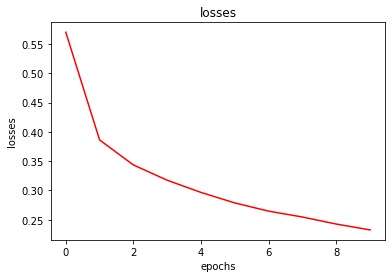

In [254]:
plt.plot(second_model_train_losses_RMSprop, color='red')
plt.title('losses')
plt.ylabel('losses')
plt.xlabel('epochs')
plt.show()

### Модель 3: ResNet

In [86]:
class ThirdModel(torch.nn.Module):
    def __init__(self):
        super(ThirdModel, self).__init__()
        self.layer1 = nn.Sequential( 
                          nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), 
                          nn.ReLU(), 
                          nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential( 
                          nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), 
                          nn.ReLU(), 
                          nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(28*14336, 1000) 
        self.fc = nn.Linear(1000, 784)
        self.fc2 = nn.Linear(784, 200)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x): 
        x = x.reshape(28, 1, 28, -1)
        out = self.layer1(x) 
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = out.reshape(-1, 28*14336)
        out = self.fc1(out) 
        out = self.fc(out) 
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return F.log_softmax(out)

Модель с RMSprop оптимизатором

In [88]:
third_model = ThirdModel().to(device='cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(third_model.parameters(), lr=0.001)

In [128]:
third_model_train_losses_RMSprop = fit(third_model, 10, train_dataloader, eval_dataloader, optimizer, criterion)

Train Epoch: 0
Loss: 0.4236 Accuracy: 84.375:   3%|▎         | 15/469 [00:00<00:34, 13.13it/s] 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Loss: 0.2656 Accuracy: 92.7083: 100%|██████████| 469/469 [00:06<00:00, 68.50it/s]
Validation Epoch: 0
Loss: 0.3041 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 72.91it/s]   
Train Epoch: 1
Loss: 0.4754 Accuracy: 82.2917: 100%|██████████| 469/469 [00:06<00:00, 74.11it/s]
Validation Epoch: 1
Loss: 0.3038 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 55.05it/s]   
Train Epoch: 2
Loss: 0.3794 Accuracy: 85.4167: 100%|██████████| 469/469 [00:06<00:00, 72.10it/s]
Validation Epoch: 2
Loss: 0.2954 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 72.68it/s]   
Train Epoch: 3
Loss: 0.4163 Accuracy: 84.375: 100%|██████████| 469/469 [00:07<00:00, 62.84it/s] 
Validation Epoch: 3
Loss: 0.2946 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 73.36it/s]   
Train Epoch: 4
Loss: 0.332 Accuracy: 89.5833: 100%|██████████| 469/469 [00:06<00:00, 68.36it/s] 
Validation Epoch: 4
Loss: 0.3013 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 73.39it/s]   
Train Epoch: 5
Loss: 0.4579 Ac

In [ ]:
plt.plot(third_model_train_losses_RMSprop, color='red')
plt.title('losses')
plt.ylabel('losses')
plt.xlabel('epochs')
plt.show()

Модель с SGD with momentum оптимизатором

In [132]:
third_model = ThirdModel().to(device='cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(third_model.parameters(), momentum=0.9, lr=0.001)

In [133]:
third_model_train_losses_SGD = fit(third_model, 10, train_dataloader, eval_dataloader, optimizer, criterion)

Train Epoch: 0
Loss: 1.5463 Accuracy: 42.7083: 100%|██████████| 469/469 [00:06<00:00, 69.32it/s]
Validation Epoch: 0
Loss: 1.4265 Accuracy: 56.25: 100%|██████████| 79/79 [00:01<00:00, 60.13it/s]  
Train Epoch: 1
Loss: 0.8504 Accuracy: 70.8333: 100%|██████████| 469/469 [00:07<00:00, 65.61it/s]
Validation Epoch: 1
Loss: 0.7024 Accuracy: 68.75: 100%|██████████| 79/79 [00:01<00:00, 72.69it/s]  
Train Epoch: 2
Loss: 0.7641 Accuracy: 72.9167: 100%|██████████| 469/469 [00:06<00:00, 67.64it/s]
Validation Epoch: 2
Loss: 0.4958 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 50.02it/s]   
Train Epoch: 3
Loss: 0.5674 Accuracy: 78.125: 100%|██████████| 469/469 [00:07<00:00, 60.22it/s] 
Validation Epoch: 3
Loss: 0.3902 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 64.98it/s]   
Train Epoch: 4
Loss: 0.5211 Accuracy: 84.375: 100%|██████████| 469/469 [00:07<00:00, 64.28it/s] 
Validation Epoch: 4
Loss: 0.3613 Accuracy: 87.5: 100%|██████████| 79/79 [00:01<00:00, 70.50it/s]   
Train Epoch: 5


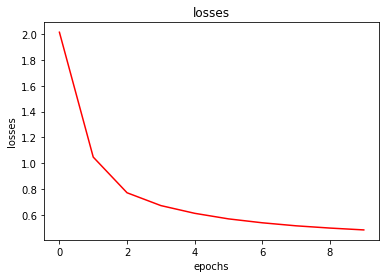

In [134]:
plt.plot(third_model_train_losses_SGD, color='red')
plt.title('losses')
plt.ylabel('losses')
plt.xlabel('epochs')
plt.show()

Лучше всего отработали модели с RMSprop оптимизатором. SGD оптимизатор очень "шумный", поэтому с ним моделям обучаться сложнее